In [263]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope

In [264]:
pagamentos = pd.read_csv('pagamentos.csv')
pagamentos.info()
# pagamentos.value_counts()
print(pagamentos.nunique())
pagamentos.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427873 entries, 0 to 427872
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   data_publicacao          427873 non-null  object
 1   fase                     427873 non-null  object
 2   credor                   427873 non-null  object
 3   valor                    427873 non-null  object
 4   numero                   427873 non-null  object
 5   cpf_ou_cnpj              427873 non-null  object
 6   data_pagamento           427873 non-null  object
 7   numero_processo          253290 non-null  object
 8   bem_ou_servico_prestado  420978 non-null  object
 9   natureza                 422333 non-null  object
 10  acao                     407378 non-null  object
 11  funcao                   407414 non-null  object
 12  subfuncao                407405 non-null  object
 13  processo_licitatorio     407396 non-null  object
 14  fonte_recurso       

,data_publicacao,fase,credor,valor,numero,cpf_ou_cnpj,data_pagamento,numero_processo,bem_ou_servico_prestado,natureza,acao,funcao,subfuncao,processo_licitatorio,fonte_recurso
0,01/01/2010,EMPENHO,METALPIRES INDUSTRIA E COM LT,"R$ 203.690,00",10000348,06.965.538/0001-00,01/01/2010,157/2009,REF AQUISICAO DE MOBILIARIOS E EQUIPAMENTOS PA...,449052090000 - Out.Equip. e Mat. Permanente,2040 - Equipar e Reequipar Unidades Escolares ...,12 - EDUCACAO,361 - ENSINO FUNDAMENTAL,PREGAO,0001 - REC.IMP.TRANSF.EDUCACAO 25%
1,01/01/2010,EMPENHO,INST.NAC.DE SEGURIDADE SOCIAL,"R$ 1.500.000,00",10000195,01.404.357/0001-51,01/01/2010,NaN,REFERENTE A DESPESA COM PARCE- LAMENTO DA DI...,469071030000 - INSS/PARCELAMENTO,2145 - Administracao de encagos especiais,28 - ENCARGOS ESPECIAIS,843 - SERVICO DA DIVIDA INTERNA,ISENTO,0000 - RECURSOS ORDINARIOS
2,01/01/2010,EMPENHO,GASAUTO LOCAC?O DE VEICULOS L,"R$ 18.816,00",113/2009,00.426.288/0001-58,01/01/2010,039/2009,locac?o de 04 motocicletas 150cc com com parti...,339039780000 - locacao de veiculos,2141 - Seguranca no transito,26 - TRANSPORTE,452 - SERVICOS URBANOS,CONVITE,0050 - REC.PROPRIAS ENT.ADM.
3,02/01/2010,EMPENHO,SALUSTIANO JOSE ALVES DIAS,"R$ 4.800,00",10000024,407.981.865-34,02/01/2010,230/2007,"TERMO DE RENOVACAO DO ADITIVO 5025271/2009, R...",339039780000 - locacao de veiculos,2097 - Pavimentacao e infra-estrutura,15 - URBANISMO,451 - INFRA-ESTRUTURA URBANA,TOMADA DE PRECO,0000 - RECURSOS ORDINARIOS
4,02/01/2010,EMPENHO,VALDEANE DOS SANTOS DIAS,"R$ 3.600,00",10000494,006.534.185-66,02/01/2010,NaN,REF. ALUGUEL DO IMOVEL ONDE FUNCIONA O NUCL...,339039100000 - Locacao de imoveis,2084 - Programa Errad.Trabalho Infantil PETI,08 - ASSISTENCIA SOCIAL,243 - ASSISTENCIA A CRIANCA E AO ADO,ISENTO,0000 - RECURSOS ORDINARIOS


# Investigar
Do print acima a gente pode ver que:

Das 427.873 entradas, só existem 193.494 números.

Existem 8831 credores (nome) mas só 7828 (cpnj). Por que? Typos etc? Conferir

Existem 193.494 números, mas só 17.919 números de processo. O que representam esses números de processo


In [265]:
# Limpando o df
pagamentos.drop(['data_publicacao'],
                inplace=True, axis=1)
pagamentos = pagamentos[pagamentos['fase'] == 'PAGAMENTO']
print(pagamentos.info())
print(pagamentos.nunique())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181527 entries, 13 to 427868
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   fase                     181527 non-null  object
 1   credor                   181527 non-null  object
 2   valor                    181527 non-null  object
 3   numero                   181527 non-null  object
 4   cpf_ou_cnpj              181527 non-null  object
 5   data_pagamento           181527 non-null  object
 6   numero_processo          97139 non-null   object
 7   bem_ou_servico_prestado  179835 non-null  object
 8   natureza                 175987 non-null  object
 9   acao                     161047 non-null  object
 10  funcao                   161068 non-null  object
 11  subfuncao                161059 non-null  object
 12  processo_licitatorio     161057 non-null  object
 13  fonte_recurso            161059 non-null  object
dtypes: object(14)
memor

In [266]:
num_entradas_repetidas = len(pagamentos)
pagamentos = pagamentos.drop_duplicates()
num_entradas_unicas = len(pagamentos)
print(f'Numero de entradas duplicadas: {num_entradas_repetidas - num_entradas_unicas}\nNumero de entradas unicas: {num_entradas_unicas}')

Numero de entradas duplicadas: 16420
Numero de entradas unicas: 165107


In [267]:
def currency_to_float(value):
    """Converte de R$ 69.848,70 (str) para 69848.70 (float)."""
    try:
        cleaned_value = value.replace("R$", "").replace(".", "").replace(",", ".")
        return float(cleaned_value)
    except ValueError:
        return

pagamentos['valor'] = pagamentos['valor'].apply(currency_to_float)
pagamentos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165107 entries, 13 to 427803
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   fase                     165107 non-null  object 
 1   credor                   165107 non-null  object 
 2   valor                    165107 non-null  float64
 3   numero                   165107 non-null  object 
 4   cpf_ou_cnpj              165107 non-null  object 
 5   data_pagamento           165107 non-null  object 
 6   numero_processo          87961 non-null   object 
 7   bem_ou_servico_prestado  163639 non-null  object 
 8   natureza                 160383 non-null  object 
 9   acao                     146340 non-null  object 
 10  funcao                   146360 non-null  object 
 11  subfuncao                146352 non-null  object 
 12  processo_licitatorio     146350 non-null  object 
 13  fonte_recurso            146352 non-null  object 
dtypes: 

In [268]:
# Investigando numero x numero_processo. O que significa numero?
gp_numero = pagamentos.groupby('numero')
print(gp_numero.count().sort_values('numero_processo', ascending=False))
print ('\n\n- # # # # # # -\n\n')
gp_numero.nunique().sort_values('numero_processo', ascending=False)

fase  credor  valor  cpf_ou_cnpj  data_pagamento  numero_processo  \
numero                                                                        
0081       153     153    153          153             153               37   
00605/10     5       5      5            5               5                5   
00073-17     5       5      5            5               5                5   
00602/10     6       6      6            6               6                5   
02076/10     4       4      4            4               4                4   
...        ...     ...    ...          ...             ...              ...   
09331-18     1       1      1            1               1                0   
09331/10     1       1      1            1               1                0   
09332-18     1       1      1            1               1                0   
09332/10     1       1      1            1               1                0   
31965-16     1       1      1            1               1    

,fase,credor,valor,numero,cpf_ou_cnpj,data_pagamento,numero_processo,bem_ou_servico_prestado,natureza,acao,funcao,subfuncao,processo_licitatorio,fonte_recurso
numero,,,,,,,,,,,,,,
0081,1,35,90,1,35,49,13,113,16,8,1,2,3,1
00602/10,1,6,6,1,6,6,5,6,6,6,5,4,5,5
00073-17,1,5,5,1,5,5,5,5,4,5,5,5,3,3
00605/10,1,5,5,1,5,5,5,5,5,5,4,3,3,4
00194-17,1,4,4,1,4,4,4,4,2,4,4,3,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
09331-18,1,1,1,1,1,1,0,1,1,1,1,1,1,1
09331/10,1,1,1,1,1,1,0,1,1,1,1,1,1,1
09332-18,1,1,1,1,1,1,0,1,0,0,0,0,0,0


In [269]:
pagamentos[pagamentos['numero'] == '440/14CP'].head()pagamentos[pagamentos['numero'] == '440/14CP'].head()

SyntaxError: invalid syntax (<ipython-input-269-9c8dad75446f>, line 1)

In [270]:
# Conferindo discrepancia entre credores e cpf_ou_cnpj (documento)
cpf_group = pagamentos.groupby('cpf_ou_cnpj').nunique().sort_values('credor', ascending=False)
cpf_group.head(10)

,fase,credor,valor,numero,cpf_ou_cnpj,data_pagamento,numero_processo,bem_ou_servico_prestado,natureza,acao,funcao,subfuncao,processo_licitatorio,fonte_recurso
cpf_ou_cnpj,,,,,,,,,,,,,,
14.043.574/0001-51,1,169,6019,9388,1,958,4,6049,23,112,16,23,5,12
01.404.357/0001-51,1,154,3023,4367,1,496,7,2990,26,119,23,26,6,7
000.000.000-00,1,62,741,1223,1,264,0,661,4,3,3,3,1,2
08.576.590/0001-07,1,23,732,974,1,149,0,894,5,23,1,5,2,2
00.857.659/0001-07,1,19,351,421,1,48,0,119,7,15,1,5,2,2
07.520.940/0001-50,1,18,80,116,1,85,0,104,7,7,3,2,2,2
02.983.473/0001-81,1,13,54,61,1,30,0,54,6,2,2,1,1,1
04.063.715/0001-36,1,11,82,85,1,37,3,71,6,2,1,1,3,3
42.743.658/0001-33,1,10,450,525,1,148,0,296,15,13,7,7,1,7


In [271]:
# Investigando cnpj com multiplos credores 
credor = pagamentos[pagamentos['cpf_ou_cnpj'] == '07.520.940/0001-50']
credor.groupby('credor').head()


,fase,credor,valor,numero,cpf_ou_cnpj,data_pagamento,numero_processo,bem_ou_servico_prestado,natureza,acao,funcao,subfuncao,processo_licitatorio,fonte_recurso
135496,PAGAMENTO,PESSOAL CIVIL,82796.69,00001/13,07.520.940/0001-50,25/01/2013,NaN,REF. A DESPESA C/ FOLHA DE PAGAMENTO DOS SERVI...,319011010000 - V.Vant.Fixas P.Civil,2047 - Manutencao da Fundacao Egberto Costa,13 - CULTURA,122 - ADMINISTRACAO GERAL,ISENTO,0000 - TESOURO
135989,PAGAMENTO,BAS¿LIO FERNANDEZ FERNANDEZ,1000.00,00060/13,07.520.940/0001-50,21/02/2013,NaN,ADIANTAMENTO EMPENHO 13000025EPARA BAS¿LIO FER...,339039990000 - Outros Serv.Terceiros,2048 - Manutencao das unidades culturais,13 - CULTURA,122 - ADMINISTRACAO GERAL,ISENTO,0000 - TESOURO
136306,PAGAMENTO,PESSOAL CIVIL,68856.54,00050/13,07.520.940/0001-50,25/02/2013,NaN,REF. A DESPESA C/ FOLHA DE PAGAMENTO DOS SERVI...,319011010000 - V.Vant.Fixas P.Civil,2047 - Manutencao da Fundacao Egberto Costa,13 - CULTURA,122 - ADMINISTRACAO GERAL,ISENTO,0000 - TESOURO
139159,PAGAMENTO,INST.NAC.DE SEGURIDADE SOCIAL,1477.66,00104/13,07.520.940/0001-50,20/03/2013,NaN,REF A DESPESAS COM INSS PATRONAL DOS SERVIDORE...,319013010000 - Cont.p/Reg.Geral Prev.INSS,2047 - Manutencao da Fundacao Egberto Costa,13 - CULTURA,122 - ADMINISTRACAO GERAL,ISENTO,0000 - TESOURO
139468,PAGAMENTO,PESSOAL CIVIL,66373.85,00062/13,07.520.940/0001-50,25/03/2013,NaN,REF. A DESPESA C/ FOLHA DE PAGAMENTO DOS SERVI...,319011010000 - V.Vant.Fixas P.Civil,2047 - Manutencao da Fundacao Egberto Costa,13 - CULTURA,122 - ADMINISTRACAO GERAL,ISENTO,0000 - TESOURO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279476,PAGAMENTO,BASÍLIO FERNANDEZ FERNANDEZ,1000.00,00176-17,07.520.940/0001-50,24/03/2017,NaN,ADIANTAMENTO EMPENHO 17000180 PARA BASÍLIO FER...,339039990000 - Outros Serv.Terceiros,2048 - Manutencao das unidades culturais,13 - CULTURA,122 - ADMINISTRACAO GERAL,ISENTO,0000 - TESOURO
280895,PAGAMENTO,ALINE SANTOS MIRANDA,1000.00,00202-17,07.520.940/0001-50,31/03/2017,NaN,ADIANTAMENTO EMPENHO 17000184SPARA ALINE SANTO...,339030990000 - Materiais de Consumo,2047 - Manutencao da Fundacao Egberto Costa,13 - CULTURA,122 - ADMINISTRACAO GERAL,ISENTO,0000 - TESOURO
280898,PAGAMENTO,ICARO ALMEIDA NERY GONZALEZ GRIMALDI,1000.00,00205-17,07.520.940/0001-50,31/03/2017,NaN,ADIANTAMENTO EMPENHO 17000183RPARA ICARO ALMEI...,339030990000 - Materiais de Consumo,2191 - Manutençao de Internet Gratuita,04 - ADMINISTRACAO,122 - ADMINISTRACAO GERAL,ISENTO,0000 - TESOURO
281889,PAGAMENTO,MARIA DE LURDES GUIMARÃES BARRETO,1000.00,00251-17,07.520.940/0001-50,04/04/2017,NaN,ADIANTAMENTO EMPENHO 17000198 PARA MARIA DE LU...,339039990000 - Outros Serv.Terceiros,2048 - Manutencao das unidades culturais,13 - CULTURA,122 - ADMINISTRACAO GERAL,ISENTO,0000 - TESOURO


O CNPJ 14.043.574/0001-51 tem 169 credores inscritos sob ele. Este CNPJ é da Prefeitura.

O CNPJ 01.404.357/0001-51 tem 154 e não parece ser um CNPJ válido tb.

O CPF 000.000.000-00 tem 69 e não parece ser um CPF válido tb.

O CNPJ 08.576.590/0001-07 tem 23 inscritos. É do Fundo de Saúde Municipal de Feira

O CNPJ 00.857.659/0001-07 tem  19. Não achei origem.

O CNPJ 07.520.940/0001-50 tem 18. É da Fundação Egberto Tavares.


Difícil. Vale mais a pena agrupar pelo nome do credor do que pelo documento, que seria o certo.

In [272]:
# Pegando somente dados pra usar na detecção de outliers
df_credores = pagamentos[['credor', 'valor']]
grupo_credores = df_credores.groupby('credor').agg(['count', 'sum'])
grupo_credores.columns = grupo_credores.columns.get_level_values(1)
grupo_credores = grupo_credores.sort_values('count', ascending=False)

grupo_credores.head(20)

,count,sum
credor,,
COELBA,5060,4.907750e+07
I.N.S.S. - FOLHA,4792,2.038635e+07
COOPERSADE COOP.S.P.ESP.SAUDE,4230,1.313888e+08
I.N.S.S. S/ PROCESSOS,2924,1.303322e+07
TELEMAR,2285,7.919212e+06
SIND EMP T.COL.FEIRA DE SANTAN,2148,1.887560e+07
AUTO POSTO GASAUTO LTDA,2027,1.453029e+07
EMBASA EMP BAIANA DE A E SANEA,1872,3.392017e+07
SERVICECOOP-COOP.S.T.E PROFISS,1512,5.229844e+07


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f753417bca0>,
      dtype=object)

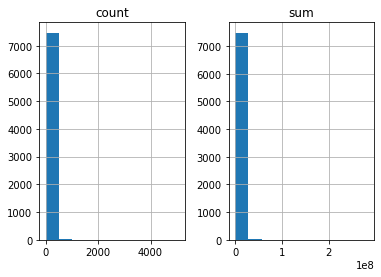

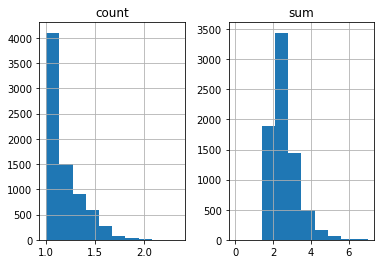

In [273]:
# Transformando as entradas pra uma forma mais gaussiana
grupo_credores.hist()

gp_cred_gaus = grupo_credores.transform(lambda x: x ** (1/10))
gp_cred_gaus.hist()

In [274]:
# Detectando outliers

#LocalOutlierFactor
lof = LocalOutlierFactor()
# lof.fit_predict(gp_cred_gaus)
gp_cred_gaus['outlier_lof'] = (lof.fit_predict(gp_cred_gaus) < 0)
grupo_credores['outlier_lof'] = (lof.fit_predict(grupo_credores) < 0)

# EllipticEnvelope (gaussian)
# TODO: verificar threshold
cov = EllipticEnvelope(random_state=0).fit(gp_cred_gaus)
gp_cred_gaus['outlier_gaus'] = (cov.predict(gp_cred_gaus) < 0)

cov = EllipticEnvelope(random_state=0).fit(grupo_credores)
grupo_credores['outlier_gaus'] = (cov.predict(grupo_credores) < 0)

gp_cred_gaus['outlier_or'] = np.logical_or(gp_cred_gaus['outlier_lof'], gp_cred_gaus['outlier_gaus'])
gp_cred_gaus['outlier_xor'] = np.logical_xor(gp_cred_gaus['outlier_lof'], gp_cred_gaus['outlier_gaus'])

grupo_credores['outlier_or'] = np.logical_or(grupo_credores['outlier_lof'], grupo_credores['outlier_gaus'])
grupo_credores['outlier_xor'] = np.logical_xor(grupo_credores['outlier_lof'], grupo_credores['outlier_gaus'])

gp_cred_gaus.head(10)

,count,sum,outlier_lof,outlier_gaus,outlier_or,outlier_xor
credor,,,,,,
COELBA,2.346470,5.876087,False,True,True,True
I.N.S.S. - FOLHA,2.333736,5.381879,True,True,True,False
COOPERSADE COOP.S.P.ESP.SAUDE,2.304804,6.484192,False,True,True,True
I.N.S.S. S/ PROCESSOS,2.221252,5.146419,True,True,True,False
TELEMAR,2.167148,4.896302,True,True,True,False
SIND EMP T.COL.FEIRA DE SANTAN,2.153790,5.340600,False,True,True,True
AUTO POSTO GASAUTO LTDA,2.141339,5.202684,False,True,True,True
EMBASA EMP BAIANA DE A E SANEA,2.124372,5.662990,False,True,True,True
SERVICECOOP-COOP.S.T.E PROFISS,2.079482,5.913558,False,True,True,True


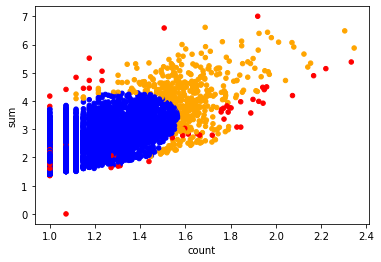

In [275]:
gp_cred_gaus['color'] = np.where(gp_cred_gaus['outlier_or'] == True, 'red', 'blue')
gp_cred_gaus['color'] = np.where(gp_cred_gaus['outlier_xor'] == True, 'orange', gp_cred_gaus['color'])

scatter_plt = gp_cred_gaus.plot.scatter(x='count', y='sum', c=gp_cred_gaus['color'])

# for i, cred in enumerate(gp_cred_gaus.index):
#     if i > 10:
#         break
#     scatter_plt.annotate(cred,
#                          (gp_cred_gaus['count'].iat[i], gp_cred_gaus['sum'].iat[i]),
#                          color=an_color(gp_cred_gaus.iloc[i])
#                           )
plt.show()

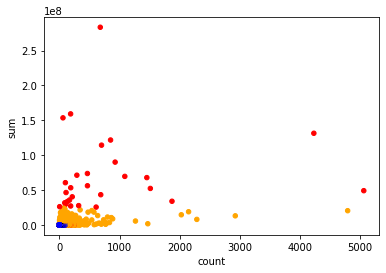

In [276]:
grupo_credores['color'] = np.where(grupo_credores['outlier_or'] == True, 'red', 'blue')
grupo_credores['color'] = np.where(grupo_credores['outlier_xor'] == True, 'orange', grupo_credores['color'])

scatter_plt = grupo_credores.plot.scatter(x='count', y='sum', c=grupo_credores['color'])

# for i, cred in enumerate(grupo_credores.index):
#     if i > 10:
#         break
#     scatter_plt.annotate(cred, (grupo_credores['count'].iat[i], grupo_credores['sum'].iat[i]))
plt.show()